In [3]:
# !pip install textblob vaderSentiment scikit-learn

In [7]:
# !pip install vaderSentiment

### Load data

In [23]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

df = pd.read_csv('../data/all_banks_reviews_cleaned.csv')

### Sentiment Analysis using TextBlob

In [24]:
def textblob_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['review'].apply(textblob_sentiment)

### Sentiment Analysis using VADER

In [25]:
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['review'].apply(vader_sentiment)


### Compare the Two Methods

In [27]:
sentiment_counts = df[['textblob_sentiment', 'vader_sentiment', 'bank']] \
    .groupby('bank') \
    .agg(lambda x: x.value_counts().to_dict())


display(sentiment_counts)

def extract_keywords(data, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = vectorizer.fit_transform(data)
    return vectorizer.get_feature_names_out()[:top_n]

# Save Output 
df.to_csv('task2_sentiment_output.csv', index=False)
print("\n Output saved to task2_sentiment_output.csv")


,textblob_sentiment,vader_sentiment
bank,,
Bank of Abyssinia,"{'positive': 466, 'neutral': 374, 'negative': ...","{'positive': 479, 'neutral': 316, 'negative': ..."
Commercial Bank of Ethiopia,"{'positive': 662, 'neutral': 272, 'negative': 66}","{'positive': 682, 'neutral': 222, 'negative': 96}"
Dashen Bank,"{'positive': 333, 'neutral': 88, 'negative': 28}","{'positive': 333, 'neutral': 90, 'negative': 26}"



 Output saved to task2_sentiment_output.csv


### Sentiment using distilbert-base-uncased-finetuned-sst-2-english

In [23]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from spellchecker import SpellChecker

# Load data
INPUT_FILE = r'..\data\all_banks_reviews_cleaned.csv'
OUTPUT_FILE = r'..\data\all_banks_reviews_with_sentiment.csv'

df = pd.read_csv(INPUT_FILE)

# Spelling correction with caching
spell = SpellChecker()
correction_cache = {}

def correct_spelling(text):
    corrected = []
    for word in str(text).split():
        if word in correction_cache:
            corrected_word = correction_cache[word]
        else:
            corrected_word = spell.correction(word)
            correction_cache[word] = corrected_word
        corrected.append(corrected_word if corrected_word else word)
    return " ".join(corrected)

df['review_corrected'] = df['review'].astype(str).apply(correct_spelling)

# Load DistilBERT sentiment model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"
)

# batch sentiment analysis
batch_size = 32
predictions = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df['review_corrected'].iloc[i:i + batch_size].tolist()
    preds = sentiment_pipeline(batch)
    predictions.extend(preds)

df['bert_sentiment'] = [p['label'].lower() for p in predictions]
df['sentiment_score'] = [p['score'] for p in predictions]

# Adjust sentiment using star rating
def adjust_sentiment(label, rating):
    if rating >= 4 and label == 'negative':
        return 'positive'
    elif rating <= 2 and label == 'positive':
        return 'negative'
    elif rating == 3:
        return 'neutral'
    return label

# Adjusting sentiment based on rating
df['adjusted_sentiment'] = [
    adjust_sentiment(label, rating) 
    for label, rating in zip(df['bert_sentiment'], df['rating'])
]

df.to_csv(OUTPUT_FILE, index=False)
print(f" Sentiment analysis complete and saved to: {OUTPUT_FILE}")


Device set to use cpu
100%|██████████| 78/78 [01:03<00:00,  1.23it/s]

 Sentiment analysis complete and saved to: ..\data\all_banks_reviews_with_sentiment.csv


C:\Users\Hp victus\AppData\Local\Temp\ipykernel_13540\3738735373.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='adjusted_sentiment', data=df, palette='Set2')


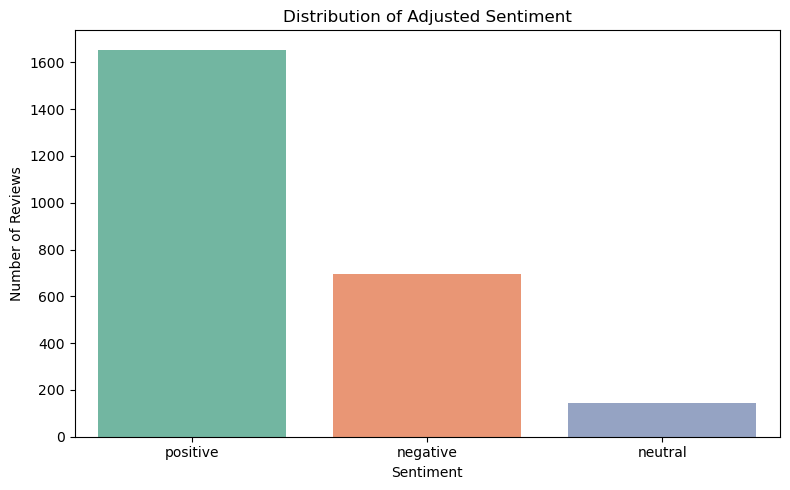

<Figure size 1000x600 with 0 Axes>

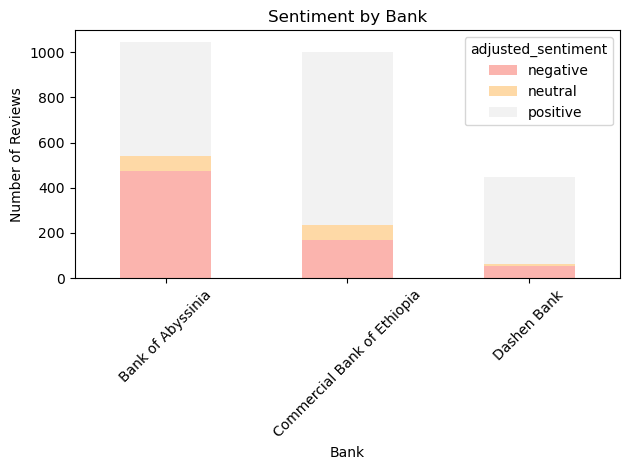

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution (Bar Plot)
plt.figure(figsize=(8, 5))
sns.countplot(x='adjusted_sentiment', data=df, palette='Set2')
plt.title("Distribution of Adjusted Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()

# Sentiment by Bank (Stacked Bar Plot)
plt.figure(figsize=(10, 6))
sentiment_by_bank = df.groupby(['bank', 'adjusted_sentiment']).size().unstack().fillna(0)
sentiment_by_bank.plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Sentiment by Bank")
plt.ylabel("Number of Reviews")
plt.xlabel("Bank")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("sentiment_by_bank.png")
plt.show()